# Coding Challenge

## 1. Get Data

Data contain numeric decimals and scientific notation. The perfect/imperfect labels are in the header row. We shall read the values in as floats, convert the labels into zero and ones, and remove the time column. We transpose the data such that each row is a single time series and the columns are specific time points.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

training_path = "datasets/training_data_external.csv"

In [2]:
with open(training_path, "r") as f:
    labels = f.readline().strip().split(",")[1:]
    observations = []
    for idx, row in enumerate(f):
        # print(row.strip().split(","))
        try:
            observations.append(list(map(float, row.strip().split(",")[1:])))
        except Exception as e:
            print(f"Error processing row {idx}: {row.strip()}")
            print(e)
            continue

print(labels[:5])
labels = np.array([1 if label == "perfect" else 0 for label in labels], dtype=np.int32)
observations = np.array(observations, dtype=np.float32).T
print(observations[10:15, 80:85]) 

    

Error processing row 100: ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,good,early,,early
could not convert string to float: ''
['imperfect', 'imperfect', 'imperfect', 'imperfect', 'imperfect']
[[ 9.379145   6.9425697  8.798071  10.003273   9.117476 ]
 [ 8.168421   8.453008   7.7504807  9.192637  10.130957 ]
 [ 8.387785   8.045827   8.497733   9.210399   9.366762 ]
 [ 9.685875   9.921623   9.946852   9.067962   9.253203 ]
 [ 8.240742   8.870279   8.01141    9.601433   9.098983 ]]


## 2. Data Understanding

Let's see how imbalanced the data actually is.

In [3]:
print(f"Number of zeros in labels: {np.sum(labels == 0)}")
print(f"Number of ones in labels: {np.sum(labels == 1)}")

Number of zeros in labels: 35
Number of ones in labels: 4


##### 2.1 The difficulty:

- imbalanced data with very few "perfect" examples - only 4
- the time series are relatively short - 100 points
- only 39 total examples

This eliminates a number of ML models that require lots of data. With data of this size, feature engineering, explicit programming, and classical statistics might be preferable over ML modeling. We shall plot the data to learn more. 

##### 2.2 Initial Data Split

Since there are only 4 perfect experiments, we shall plan for an eventual leave-one-out cross validation and use the training set of the first split for exploration

In [4]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=9)

training_idx, _ = next(kfold.split(observations, labels))
training_obs = observations[training_idx]
training_lbs = labels[training_idx]

##### 2.3 Plot the Time Series

The following plots the observations labeled imperfect as red and perfect as blue:

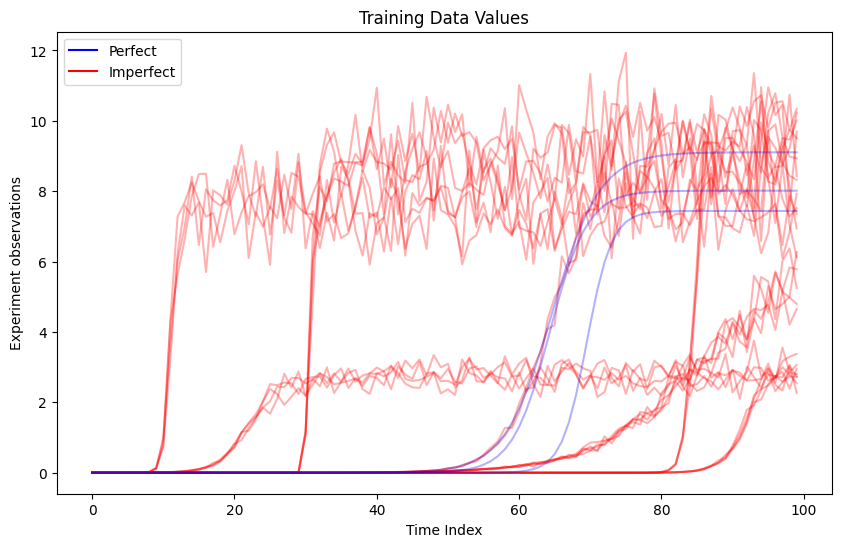

In [5]:
plt.figure(figsize=(10, 6))
time_axis = np.arange(len(training_obs[0]))

for i in range(len(training_obs)):
    plt.plot(
        time_axis, training_obs[i], 
        color='b' if training_lbs[i] else 'r', 
        alpha=0.3,
    )

plt.legend(handles=[
    mlines.Line2D([], [], color='b', label='Perfect'),
    mlines.Line2D([], [], color='r', label='Imperfect'),
])
plt.title("Training Data Values")
plt.xlabel("Time Index")
plt.ylabel("Experiment observations")
plt.show()

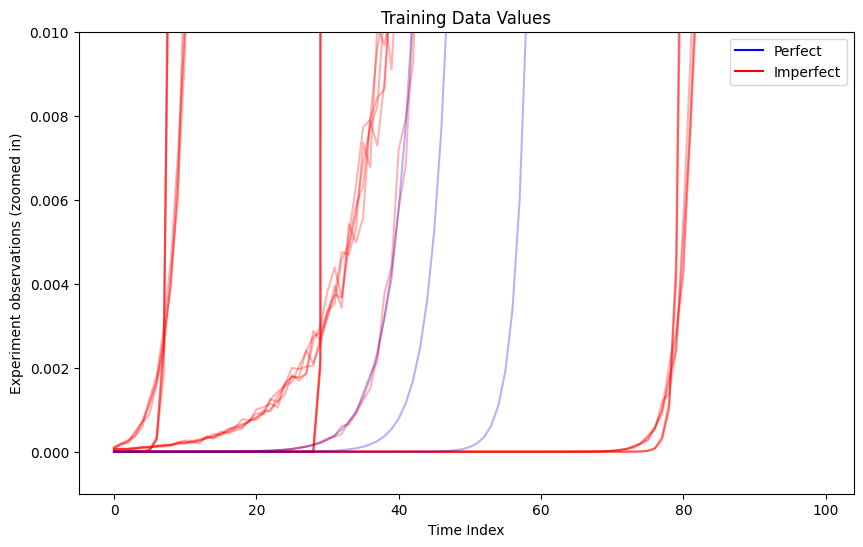

In [6]:
### Zoom in on values close to zero
plt.figure(figsize=(10, 6))
time_axis = np.arange(len(training_obs[0]))

for i in range(len(training_obs)):
    plt.plot(
        time_axis, training_obs[i], 
        color='b' if training_lbs[i] else 'r', 
        alpha=0.3,
    )

plt.legend(handles=[
    mlines.Line2D([], [], color='b', label='Perfect'),
    mlines.Line2D([], [], color='r', label='Imperfect'),
])
plt.title("Training Data Values")
plt.xlabel("Time Index")
plt.ylabel("Experiment observations (zoomed in)")
plt.ylim(-0.001, 0.01)
plt.show()

Observations:

- Every experiment seem to produce logistic curve with varying amount of noise
- Curve for the perfect experiments are smooth compared to imperfect
- Curve for the perfect experiments plateau between 6 and 10
- Curve for the perfect experiments has inflection point between 50 and 70
- For curve of the imperfect experiments, the noise seems to increase as value increase

#### 2.4 Potential Features:

The following features may be interesting

- noise/perturbation measurements
- Logistic curve parameters: plateau/max value, inflection time, inflection slope

#### 2.5 Noise/Perturbations

When noise is high, we should expect the absolute value of differences between adjacent points to be greater than those without noise. We should also expect the absolute value of difference of difference (like a second derivative) to be greater than those without noise.

$$ |x'_i| = |x_i - x_{i-1}|, \forall i \in \{2,3,4,..., n\}$$

$$ |x''_i| = |x_i - 2x_{i-1} + x_{i-2}|, \forall i \in \{3,4,5,..., n\}$$

#### 2.5.1 Noise/Perturbations: Histogram for $|x'_i|$

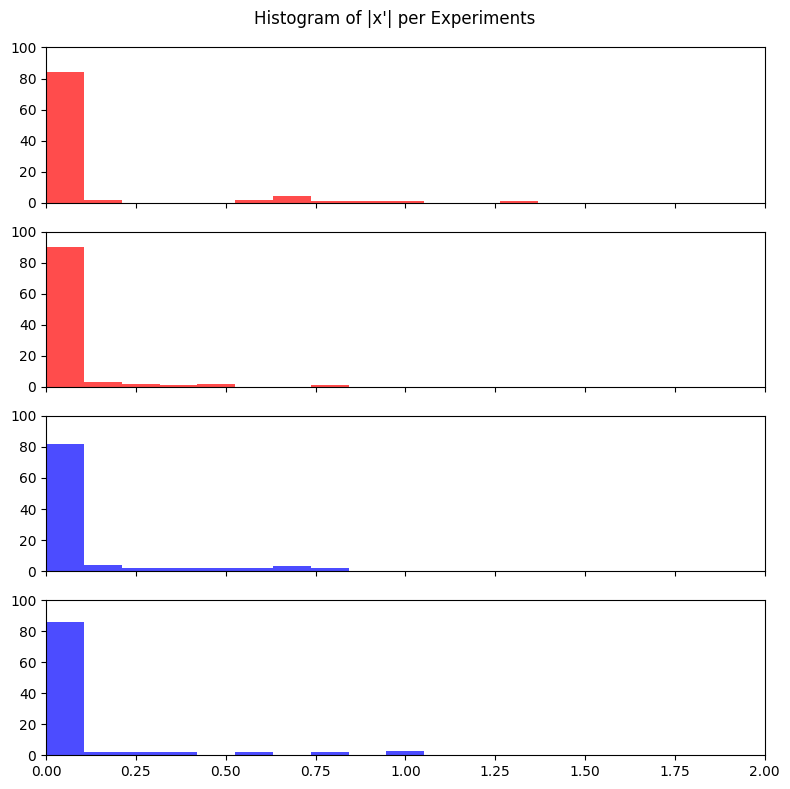

In [11]:
delta1 = np.abs(np.diff(training_obs, axis=1))

fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
bins = np.linspace(0, 2, 20)
axes[0].hist(delta1[0], bins=bins, alpha=0.7, color='r', )
axes[1].hist(delta1[20], bins=bins, alpha=0.7, color='r', )
axes[2].hist(delta1[-1], bins=bins, alpha=0.7, color='b')
axes[3].hist(delta1[-2], bins=bins, alpha=0.7, color='b')

for ax in axes:
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 100)

plt.suptitle("Histogram of |x'| per Experiments")
plt.tight_layout()
plt.show()


#### 2.5.2 Noise/Perturbations: Histogram for $|x''_i|$

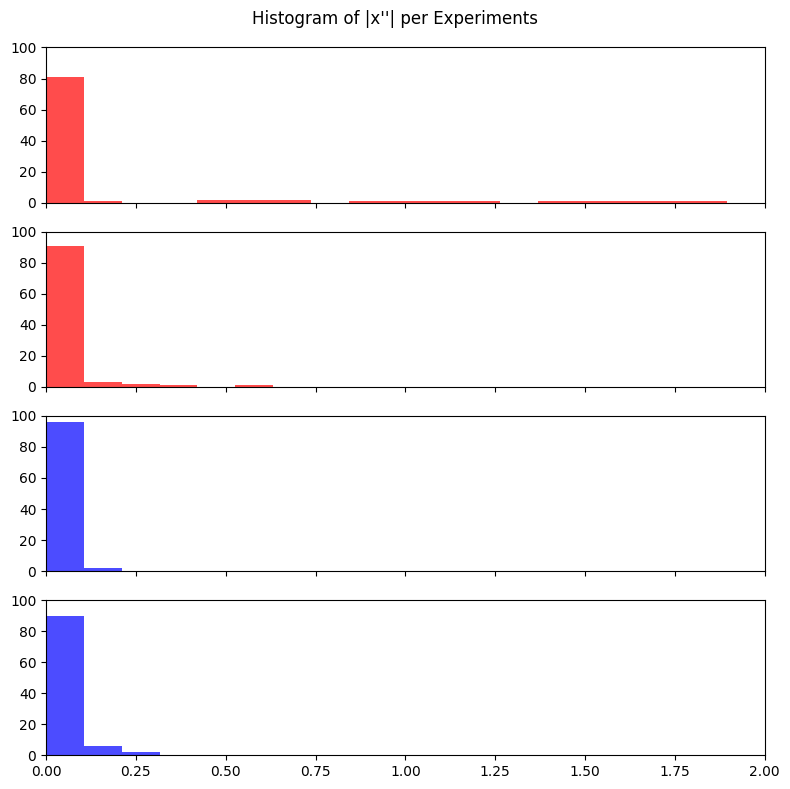

In [12]:
delta2 = np.abs(np.diff(np.diff(training_obs, axis=1)))

fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
bins = np.linspace(0, 2, 20)
axes[0].hist(delta2[0], bins=bins, alpha=0.7, color='r', )
axes[1].hist(delta2[20], bins=bins, alpha=0.7, color='r', )
axes[2].hist(delta2[-1], bins=bins, alpha=0.7, color='b')
axes[3].hist(delta2[-2], bins=bins, alpha=0.7, color='b')

for ax in axes:
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 100)

plt.suptitle("Histogram of |x''| per Experiments")
plt.tight_layout()
plt.show()


Unexpectly, both perfect and imperfect experiment showed high values in $ |x'_i| $ . This is contributed by the rapid growth phase in the logistic curve, not a part of the noise. Fortunately, $ |x''_i| $ shows much tighter histogram distributions for perfect experiments compared to that of the imperfect.  

#### 2.5.3 Noise/Perturbations: $|x'_i|$ versus $|x''_i|$

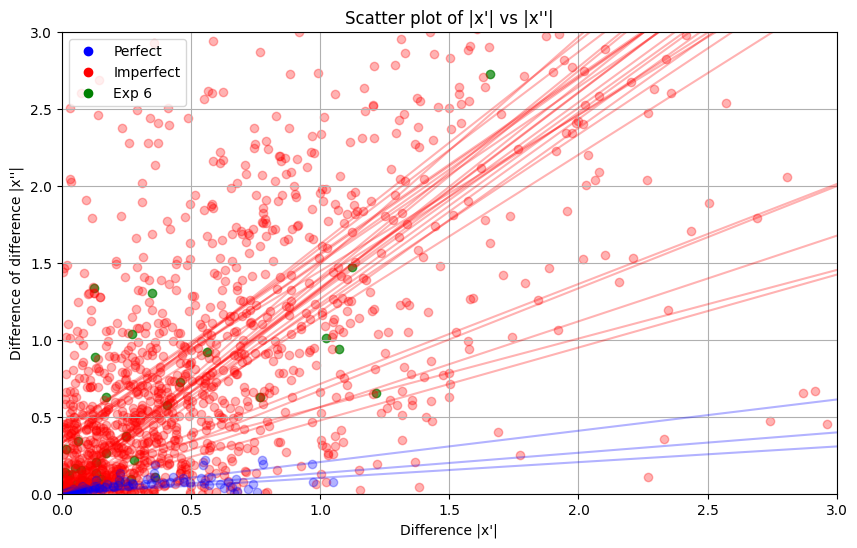

In [13]:
### plot x' against x'' for all experiments and color by label
plt.figure(figsize=(10, 6))
for i in range(len(training_obs)):
    if i== 5:
        plt.scatter(
            delta1[i][1:], delta2[i], 
            color='g', 
            alpha=0.7,
        )
    else:       
        plt.scatter(
            delta1[i][1:], delta2[i], 
            color='b' if training_lbs[i] else 'r', 
            alpha=0.3,
        )
    ### linear regression for each experiment 
    coeffs = np.polyfit(delta1[i][1:], delta2[i], 1)
    x_fit = np.linspace(0, 3, 100)
    y_fit = np.polyval(coeffs, x_fit)
    plt.plot(x_fit, y_fit, color='b' if training_lbs[i] else 'r', alpha=0.3)

plt.legend(handles=[
    mlines.Line2D([], [], color='b', marker='o', linestyle='None', label='Perfect'),
    mlines.Line2D([], [], color='r', marker='o', linestyle='None', label='Imperfect'),
    mlines.Line2D([], [], color='g', marker='o', linestyle='None', label='Exp 6'),
])
plt.title("Scatter plot of |x'| vs |x''|")
plt.xlabel("Difference |x'|")
plt.ylabel("Difference of difference |x''|")
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.grid()
plt.show()

With respect to noise, we can interpret difference as amplitude and difference of difference as frequency. The imperfect experiments show "higher frequency" noise compared to perfect experiments.

#### 2.5.4 Noise/Perturbations: $|x'_i|$ versus Observations

As mentioned above, the noise seems to increase as value increase for imperfect experiments. We can use $ |x'_i| $ to crudely represent the amplitude of the noise, and plot $ |x'_i| $ against the experimental observations:

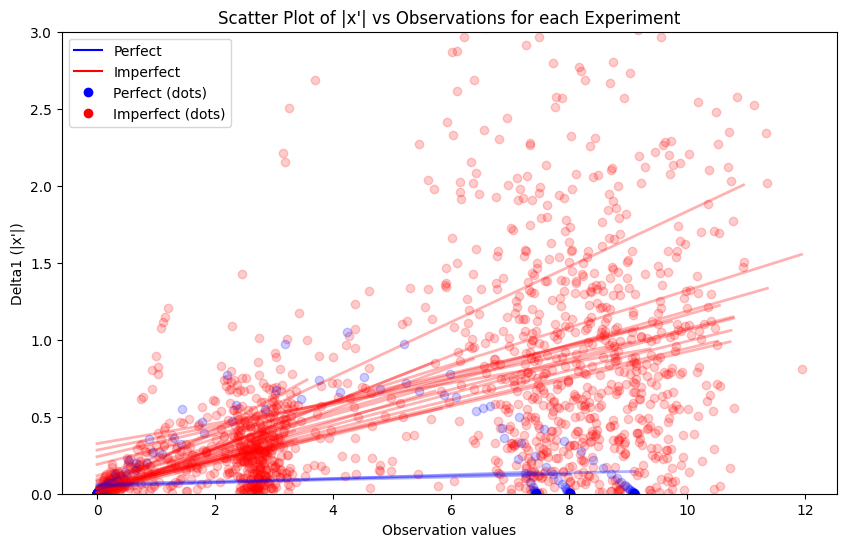

In [14]:
plt.figure(figsize=(10, 6))
for i in range(len(training_obs)):
    # Scatter plot of delta1 against experiments
    plt.scatter(
        training_obs[i][1:], delta1[i], 
        color='b' if training_lbs[i] else 'r', 
        alpha=0.2
    )
    # Fit a linear regression line
    coeffs = np.polyfit(training_obs[i][1:], delta1[i], 1)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(min(training_obs[i][1:]), max(training_obs[i][1:]), 100)
    plt.plot(x_fit, poly(x_fit), color='b' if training_lbs[i] else 'r', linewidth=2, alpha=0.3)

plt.legend(handles=[
    mlines.Line2D([], [], color='b', label='Perfect'),
    mlines.Line2D([], [], color='r', label='Imperfect'),
    mlines.Line2D([], [], color='b', marker='o', linestyle='None', label='Perfect (dots)'),
    mlines.Line2D([], [], color='r', marker='o', linestyle='None', label='Imperfect (dots)'),
])
plt.title("Scatter Plot of |x'| vs Observations for each Experiment")
plt.xlabel("Observation values")
plt.ylabel("Delta1 (|x'|)")
plt.ylim(0,3)
plt.show()


As expected, the perfect observation values (blue dots) are mostly near zero, with selected dots in the middle representing the rapid growth phase. A regression of $ |x'_i| $ versus observation values (blue lines) yield a slope of close to zero.  

On the contrary, the imperfect observation values (red dots) are more distributed across the ranges. A regression of $ |x'_i| $ versus observation values (red lines) yield a consistant, closely distributed, **positive** slope. 

In general, imperfect experiments show a positive correlation between observation values and $ |x'_i| $. Another word, the larger the observed value, the larger the noise amplitude.

Note that the imperfect experiments would only show a positive $ |x'_i| $ versus observation value slope if the curve reaches the rapid growth phase. Based on this trend, we would not detect noise if the observations stay at baseline.


#### 2.6 Logistic Curve Parameters

All experiments resemble a logistic curve:

1. initial low signal
2. rapid growth phase
3. eventual plateau

A logistic curve can be fitted using 5PL function shown below:

$$ f(x) = d + \frac{a-d}{[1 + (\frac{x}{c})^b]^g} $$

where increasing each parameter will have the following effect on the curve:

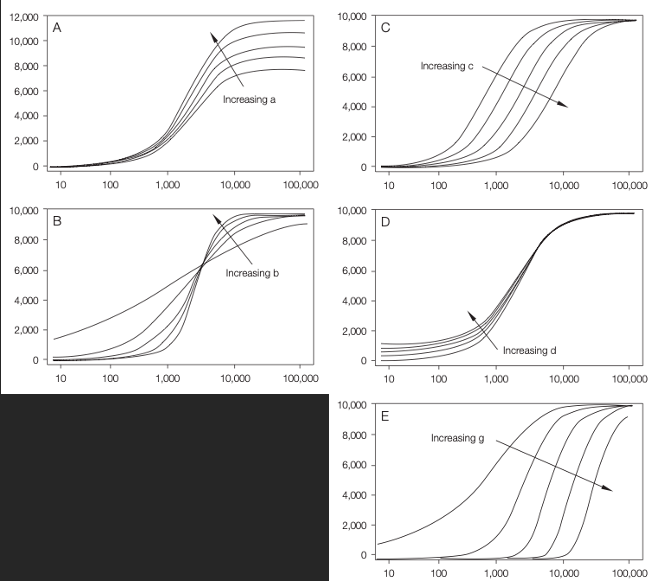

a = raise upper asymptote  
b = increase slope  
c = shift inflection point towards the right   
d = raise lower asymptote   
g = increase slope and shift inflection towards the right   



Note that this equation makes no assumptions about the minimum, maximum, or symmetry. In addition to the parameters, the RMSE shall be calculated as an additional feature.



#### 2.6.1 Logistic Curve Parameters: Fitting


/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/923031550.py:2: RuntimeWarning: divide by zero encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/923031550.py:2: RuntimeWarning: overflow encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/923031550.py:2: RuntimeWarning: invalid value encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/923031550.py:2: RuntimeWarning: divide by zero encountered in divide
  return d + (a - d) / ((1 + (x / c)**b)**g)


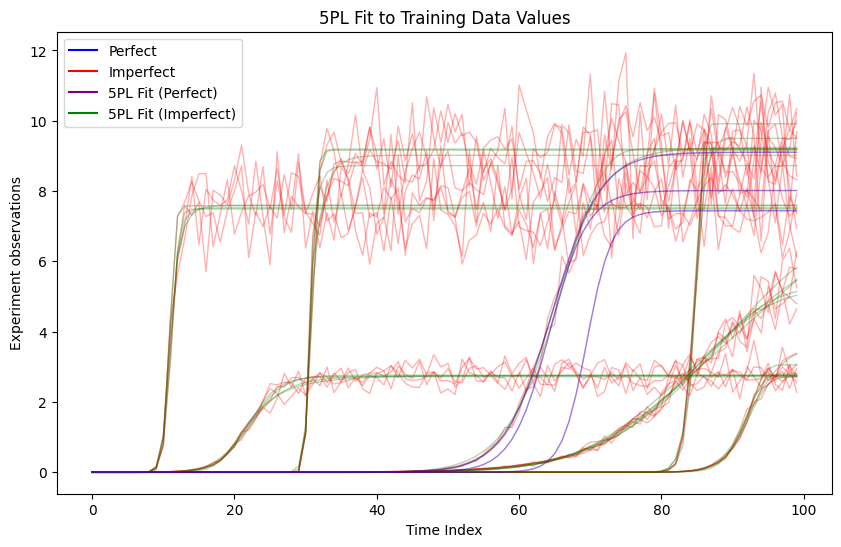

In [15]:
def logistic_5pl(x, a, b, c, d, g):
    return d + (a - d) / ((1 + (x / c)**b)**g)

params = []
plt.figure(figsize=(10, 6))
time_axis = np.arange(len(training_obs[0]))
for i in range(len(training_obs)):
    ### plot original data
    plt.plot(
        time_axis, training_obs[i], 
        color='b' if training_lbs[i] else 'r',
        alpha=0.3,
        linewidth=1,  
    )
    ### fit the 5PL function to the data
    popt, pcov = curve_fit(logistic_5pl, time_axis, training_obs[i], maxfev=1000000)
    error = np.sqrt(np.mean((logistic_5pl(time_axis, *popt) - training_obs[i])**2))
    params.append((*popt, error))
    x_fit = np.linspace(min(time_axis), max(time_axis), 100)
    y_fit = logistic_5pl(x_fit, *popt)
    plt.plot(
        x_fit, y_fit, 
        color='purple' if training_lbs[i] else 'green', 
        linewidth=1, 
        alpha=0.3,
        label=f"Fit {training_lbs[i]}"
    )

plt.legend(handles=[
    mlines.Line2D([], [], color='b', label='Perfect'),
    mlines.Line2D([], [], color='r', label='Imperfect'),
    mlines.Line2D([], [], color='purple', label='5PL Fit (Perfect)'),
    mlines.Line2D([], [], color='green', label='5PL Fit (Imperfect)'),
])
plt.title("5PL Fit to Training Data Values")
plt.xlabel("Time Index")
plt.ylabel("Experiment observations")
plt.show()


The 5PL curves for perfect experiments (purple and blue) looks like exact fits. The 5PL curves for imperfect experiments (green and red) follow the general trend and ignores the noise. Note that some imperfect curves follow similar path as the perfect curves (almost overlapping curves). This observation suggests that the 5PL parameters are sufficient to distinquish between perfect and imperfect experiments.

Now that we have the curve parameters, let's explore potential relationships and correlations.

#### 2.6.2 Logistic Curve Parameters: Noise and Fitting Error

We can plot the RMSE for each experiment. Due to noise, we would expect the perfect experiment to show low RMSE.

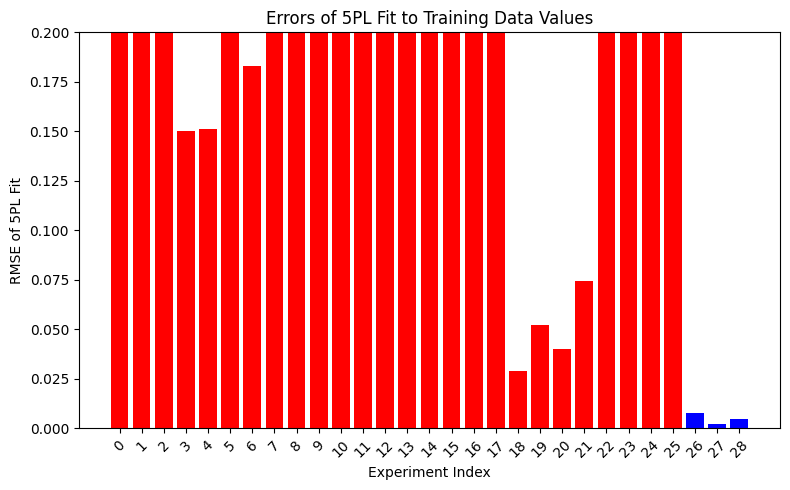

In [16]:
plt.figure(figsize=(8, 5))
plt.bar(
    range(len(params)), 
    [param[-1] for param in params], 
    color=['b' if label else 'r' for label in training_lbs]
)
plt.title("Errors of 5PL Fit to Training Data Values")
plt.xlabel("Experiment Index")
plt.ylabel("RMSE of 5PL Fit")
plt.xticks(range(len(params)), labels=range(len(params)), rotation=45)
plt.ylim(0, 0.2)
plt.tight_layout()
plt.show()


As expected, the perfect experiments in blue show low RMSE. Note number 18, 19, 20, and 21. Why do they have low RMSE? We shall plot these 4 experiments in green.

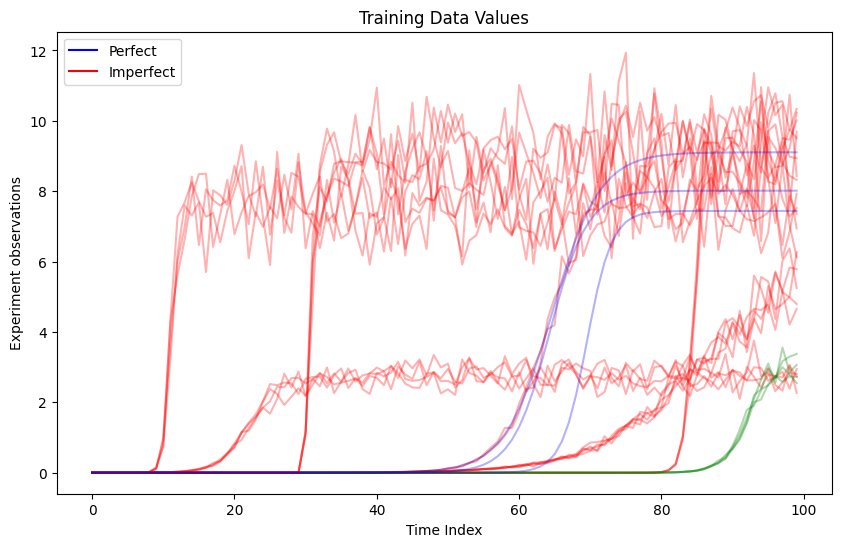

In [17]:
plt.figure(figsize=(10, 6))
time_axis = np.arange(len(training_obs[0]))

for i in range(len(training_obs)):
    if 17 < i < 22:
        plt.plot(
            time_axis, training_obs[i], 
            color='g', 
            alpha=0.3,
        )
    else:
        plt.plot(
            time_axis, training_obs[i], 
            color='b' if training_lbs[i] else 'r', 
            alpha=0.3,
        )

plt.legend(handles=[
    mlines.Line2D([], [], color='b', label='Perfect'),
    mlines.Line2D([], [], color='r', label='Imperfect'),
])
plt.title("Training Data Values")
plt.xlabel("Time Index")
plt.ylabel("Experiment observations")
plt.show()

The curves in green showed low RMSE similar to that of the perfect experiments. These experiments have a late rapid growth period, shortening the amount of noise produced at the plateau and reducing the overall RMSE. We shall handle this using the 5PL parameters later on.

#### 2.6.3 Logistic Curve Parameters: Correlations

In [18]:
df = pd.DataFrame(params, columns=["a", "b", "c", "d", "g", "error"])
df["label"] = training_lbs
# df
df.head()

,a,b,c,d,g,error,label
0,-0.002225,92.264468,87.026906,9.914416,9.156527,0.245184,0
1,-0.002385,95.413339,85.050347,9.499316,1.378353,0.245753,0
2,0.002590,103.486636,94.002893,9.196792,34320.132327,0.436443,0
3,0.013200,11.625490,76.115582,12.120283,0.193875,0.150236,0
4,0.010255,9.601034,214.993358,5.275425,6274.342249,0.151252,0


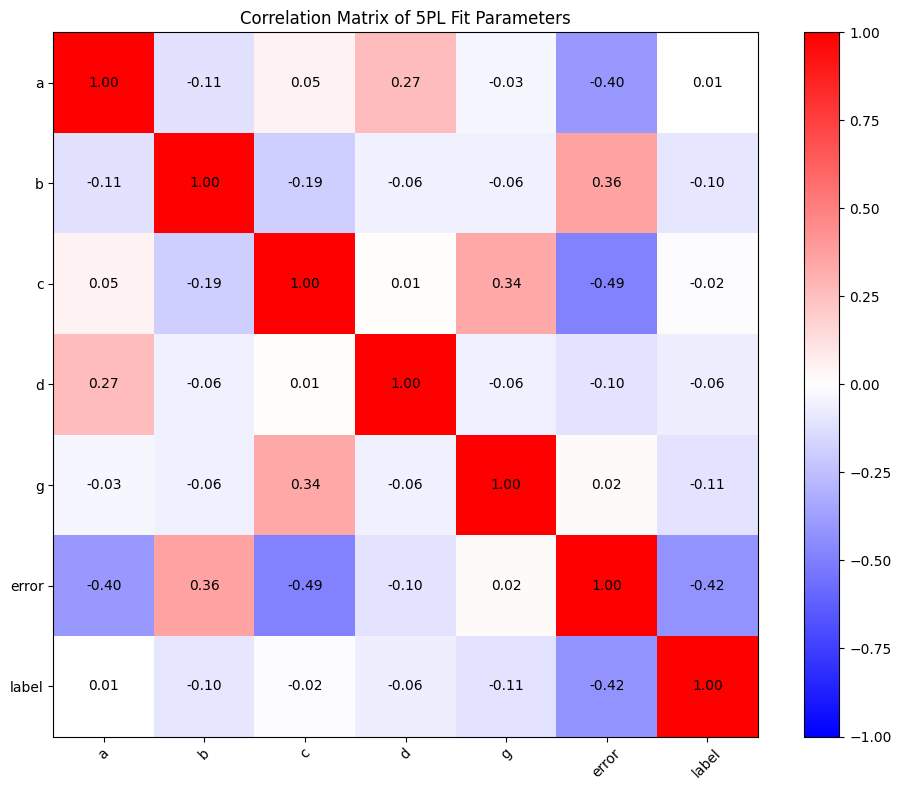

In [19]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
plt.imshow(
    correlation_matrix, cmap='bwr', 
    interpolation='nearest',
    vmin=-1, vmax=1
)

# Annotate each cell with the correlation value
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(
            j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
            ha="center", va="center", color="black", fontsize=10
        )

plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Correlation Matrix of 5PL Fit Parameters")
plt.tight_layout()
plt.show()

Correlation confirms the relationship between error and label.

The heatmap does not show any significant linear correlation between the 5PL parameters and target label. Perhaps the relationships are non-linear. 

#### 2.6.4 Logistic Curve Parameters: c versus RMSE

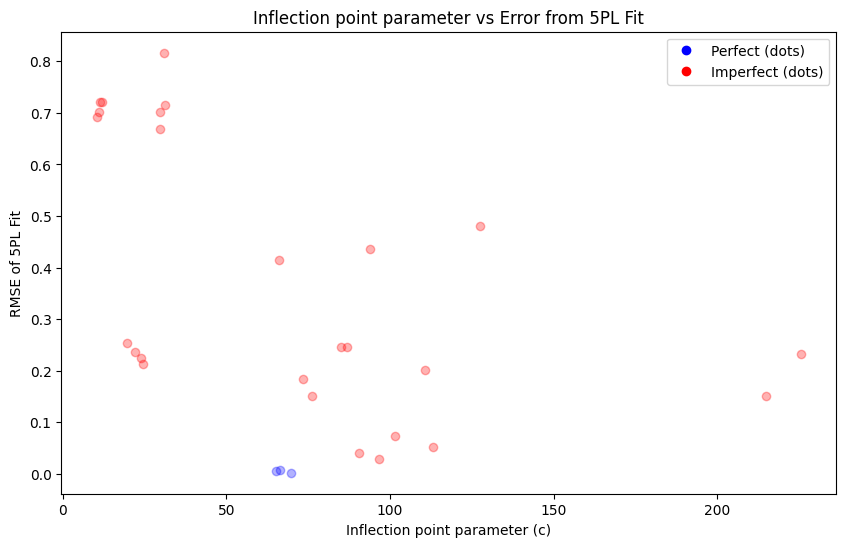

In [20]:
### Plot c versus g for all experiments, color by label
plt.figure(figsize=(10, 6))
for i in range(len(df)):
    plt.scatter(
        df["c"][i], df["error"][i], 
        color='b' if df["label"][i] else 'r', 
        alpha=0.3, 
    )
plt.xlabel("Inflection point parameter (c)") 
plt.ylabel("RMSE of 5PL Fit")
plt.title("Inflection point parameter vs Error from 5PL Fit")
# plt.xlim(0, 50)
plt.legend(handles=[
    mlines.Line2D([], [], color='b', marker='o', linestyle='None', label='Perfect (dots)'),
    mlines.Line2D([], [], color='r', marker='o', linestyle='None', label='Imperfect (dots)'),
])
plt.show()

Like $|x'_i|$ versus $|x''_i|$, parameter C seems to group the perfect experiments close togather despite not being able to perfectly seperate the two target categories. This may be useful to distinquish the imperfect experiments with low noise from the perfect experiments mentioned previously.

## 3. Modeling

#### 3.1 Regression and Parametric Modeling

Based on the data exploration above, we found various features that can visually distinquish the target categories (linearly distinquishable). The time series data consistantly follow a logistic curve with various amount of noise, so they are "well-understood". These descriptions along with the fact that the data set is small and imbalanced lends itself to the application of regression and parametric modeling. Although they are not traditionally classification models, we can apply thresholds to produce boolean outputs representing imperfect and perfect. When the criteria are met and the appropriate functions are applied, the model can provide good fit (as opposed to under- or over-fit) despite the limitation mentioned.

#### 3.2 Other Considerations

Decision Tree Classification:

Decision trees are often a good choice for determining threshold from features through data. It is often suitable in situations with smaller data sets. A decision was made not to use it. The perfect experiment category are too small, so letting the algorithm decide the cutoff threshold may lead to unnecessary overfitting even if the appropriate decision tree regularizations are applied. 

Anomaly Detection:  

For many imbalanced data situations, one can frame the problem as anomaly detection problem. The technique allow us to safely use various data generation techniques to "balance" the dataset. Anomaly detection usually have fewer records in the anomaly category where the anomalies are deemed outliers, but sufficiently dense data in the normal category. Based on the label names in this problem, perfect and imperfect, we have the opposit scenario: few normal outcomes (perfect) and many anomalies (imperfect). Thus, decision was made to avoid anomaly detection and proceed with curve fitting on 5PL (parametric modeling).

#### 3.3 Choosen Features

- **c parameter**: calculated from fitting 5PL, this parameter indicate how far towards the right a particular curve has shifted. We expect perfect experiments to reside at a certain range.

- **RMSE**: the root mean squared error (RMSE) of the 5PL fit determines the amount of noise in the observations that deviate from the 5PL curve. The perfect experiments should be a close fit with low RMSE.

In addition to the features for classification, we need to ensure that the input data can be used for curve fitting of the 5PL function. Here are the criteria for data validation:

- **min**: aggregated minimum of the time series. This must be between a range of values
- **max**: aggregated maximum of the time series. This must be between a range of values

#### 3.4 Data Splitting Revisited (Potential Cross Validation)

As mentioned in the beginning, the perfect category is small (only 4 examples), so we planned to use leave-one-out cross validation during evaluation. However, our parametric model does not need to be trained, so rotating through each fold of cross validation does not change the model weights. The only difference would be the removal of one perfect example and a quarter of the imperfect example.

Thus, a decision was made to not conduct cross validation. Instead, we shall choose the classification thresholds (hyperparameters) based on the first training data fold and evaluate model performance on whole data set rather than conducting a cross validation. Since we have extensively explored the small data set and decided on a relatively simple parametric model, the likelihood of overfitting on training data is low. Of course, overfitting is a risk in general with what was provided so far.

In [21]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=9)
training_idx, _ = next(kfold.split(observations, labels))
training_obs = observations[training_idx]
training_lbs = labels[training_idx]


#### 3.5 Configs and Hyperparameters

For parametrized models, the hyperparameters are the thresholds used for classification. Besides classification, we shall ensure that the input data is within certain accepted range for data validation purposes. Once input data is validated, we shall find the threshold for cparam and RMSE to make the correct classification.

Data Validation thresholds:
- min range
- max range

Prediction thresholds:
- cparam
- RMSE

#### 3.5.1 Data Validation Thresholds

Once again, we plot the training set time series. We shall determine the thresholds visually.

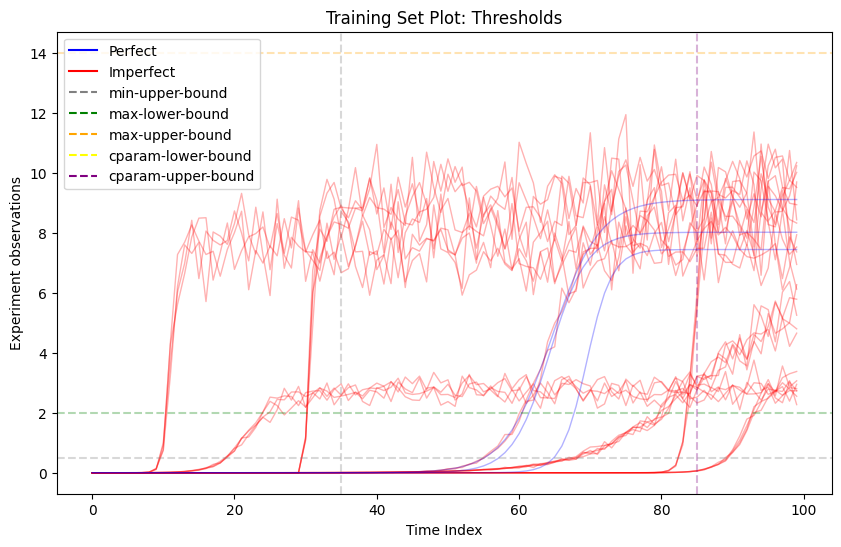

In [22]:
plt.figure(figsize=(10, 6))
time_axis = np.arange(len(training_obs[0]))
for i in range(len(training_obs)):
    plt.plot(
        time_axis, training_obs[i], 
        color='b' if training_lbs[i] else 'r',
        alpha=0.3,
        linewidth=1,  
    )

### draw horizontal lines for min and max
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
plt.axhline(y=2.0, color='green', linestyle='--', alpha=0.3)
plt.axhline(y=14.0, color='orange', linestyle='--', alpha=0.3)
### draw vertical lines
plt.axvline(x=35, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=85, color='purple', linestyle='--', alpha=0.3)

plt.legend(handles=[
    mlines.Line2D([], [], color='b', label='Perfect'),
    mlines.Line2D([], [], color='r', label='Imperfect'),
    mlines.Line2D([], [], linestyle='--', color='gray', label='min-upper-bound'),
    mlines.Line2D([], [], linestyle='--', color='green', label='max-lower-bound'),
    mlines.Line2D([], [], linestyle='--', color='orange', label='max-upper-bound'),
    mlines.Line2D([], [], linestyle='--', color='yellow', label='cparam-lower-bound'),
    mlines.Line2D([], [], linestyle='--', color='purple', label='cparam-upper-bound'),
])
plt.title("Training Set Plot: Thresholds")
plt.xlabel("Time Index")
plt.ylabel("Experiment observations")
plt.show()

For data validation, we expect the inputs to have the following:
- a baseline of zero or above
- a baseline to not exceed 0.5
- a plateau to be at least 2.0
- a plateau to not exceed 14

As mentioned previously, we deem the curves that reach the growth phase too early or too late as imperfect. Thus, the lateral position of the inflection point in 5PL, c-param, shall be bounded to between 35 and 85.

Note that these threshold and bounds are chosen with a large margin of error to reduce potential overfitting.

#### 3.5.2 RMSE and Prediction Threshold

/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/923031550.py:2: RuntimeWarning: divide by zero encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/923031550.py:2: RuntimeWarning: overflow encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/923031550.py:2: RuntimeWarning: invalid value encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/923031550.py:2: RuntimeWarning: divide by zero encountered in divide
  return d + (a - d) / ((1 + (x / c)**b)**g)


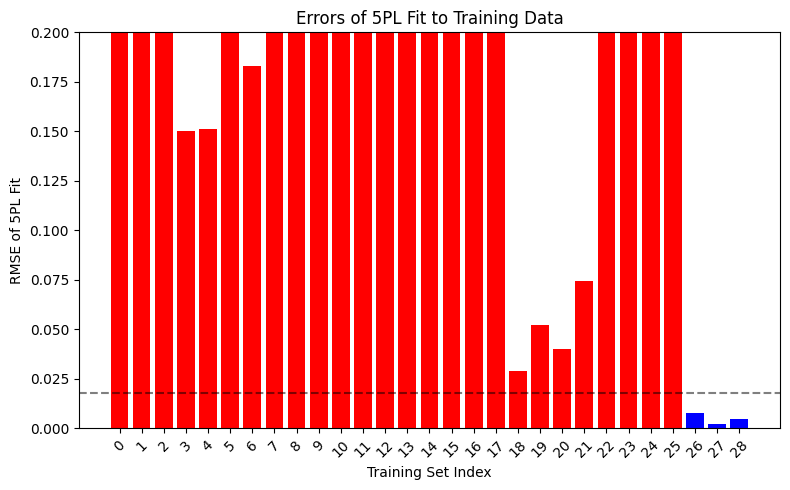

In [23]:
training_features = []
time_axis = np.arange(len(observations[0]))
for obs in training_obs:
    popt, _ = curve_fit(logistic_5pl, time_axis, obs, maxfev=1000000)
    
    # Calculate RMSE
    fitted_values = logistic_5pl(time_axis, *popt)
    rmse = np.sqrt(np.mean((fitted_values - obs) ** 2))
    training_features.append((popt[2], rmse))
    
plt.figure(figsize=(8, 5))
plt.bar(
    range(len(training_features)), 
    [feature[1] for feature in training_features], 
    color=['b' if label else 'r' for label in training_lbs]
)
plt.axhline(y=0.018, color='black', linestyle='--', alpha=0.5)
plt.title("Errors of 5PL Fit to Training Data")
plt.xlabel("Training Set Index")
plt.ylabel("RMSE of 5PL Fit")
plt.xticks(range(len(training_features)), labels=range(len(training_features)), rotation=45)
plt.ylim(0, 0.2)
plt.tight_layout()
plt.show()

For RMSE, we pick a value above the blue bars and below the red bars. As discussed previously, experiment 18, 19, 20, and 21 are classified into the imperfect category through the c-param bounds. Thus, picking a larger RMSE threshold pose little risk to model performance. 

#### 3.5.3 Finalized Configs

The final thresholds and bounds are listed below.

In [24]:
import json
model_configs = {
    "validation": {
        "min-lower-bound": 0.0,
        "min-upper-bound": 0.5,
        "max-lower-bound": 2.0,
        "max-upper-bound": 14.0,
        "rmse-upper-bound": 5.0,
    },
    "prediction": {
        "cparam-lower-bound": 35.0,
        "cparam-upper-bound": 85.0,
        "rmse-threshold": 0.018,
    }
}

with open("configs/model-configs-1-0-0.json", "w") as f:
    json.dump(model_configs, f, indent=4)

#### 3.6 Model Inference

The code below implements the following logic:

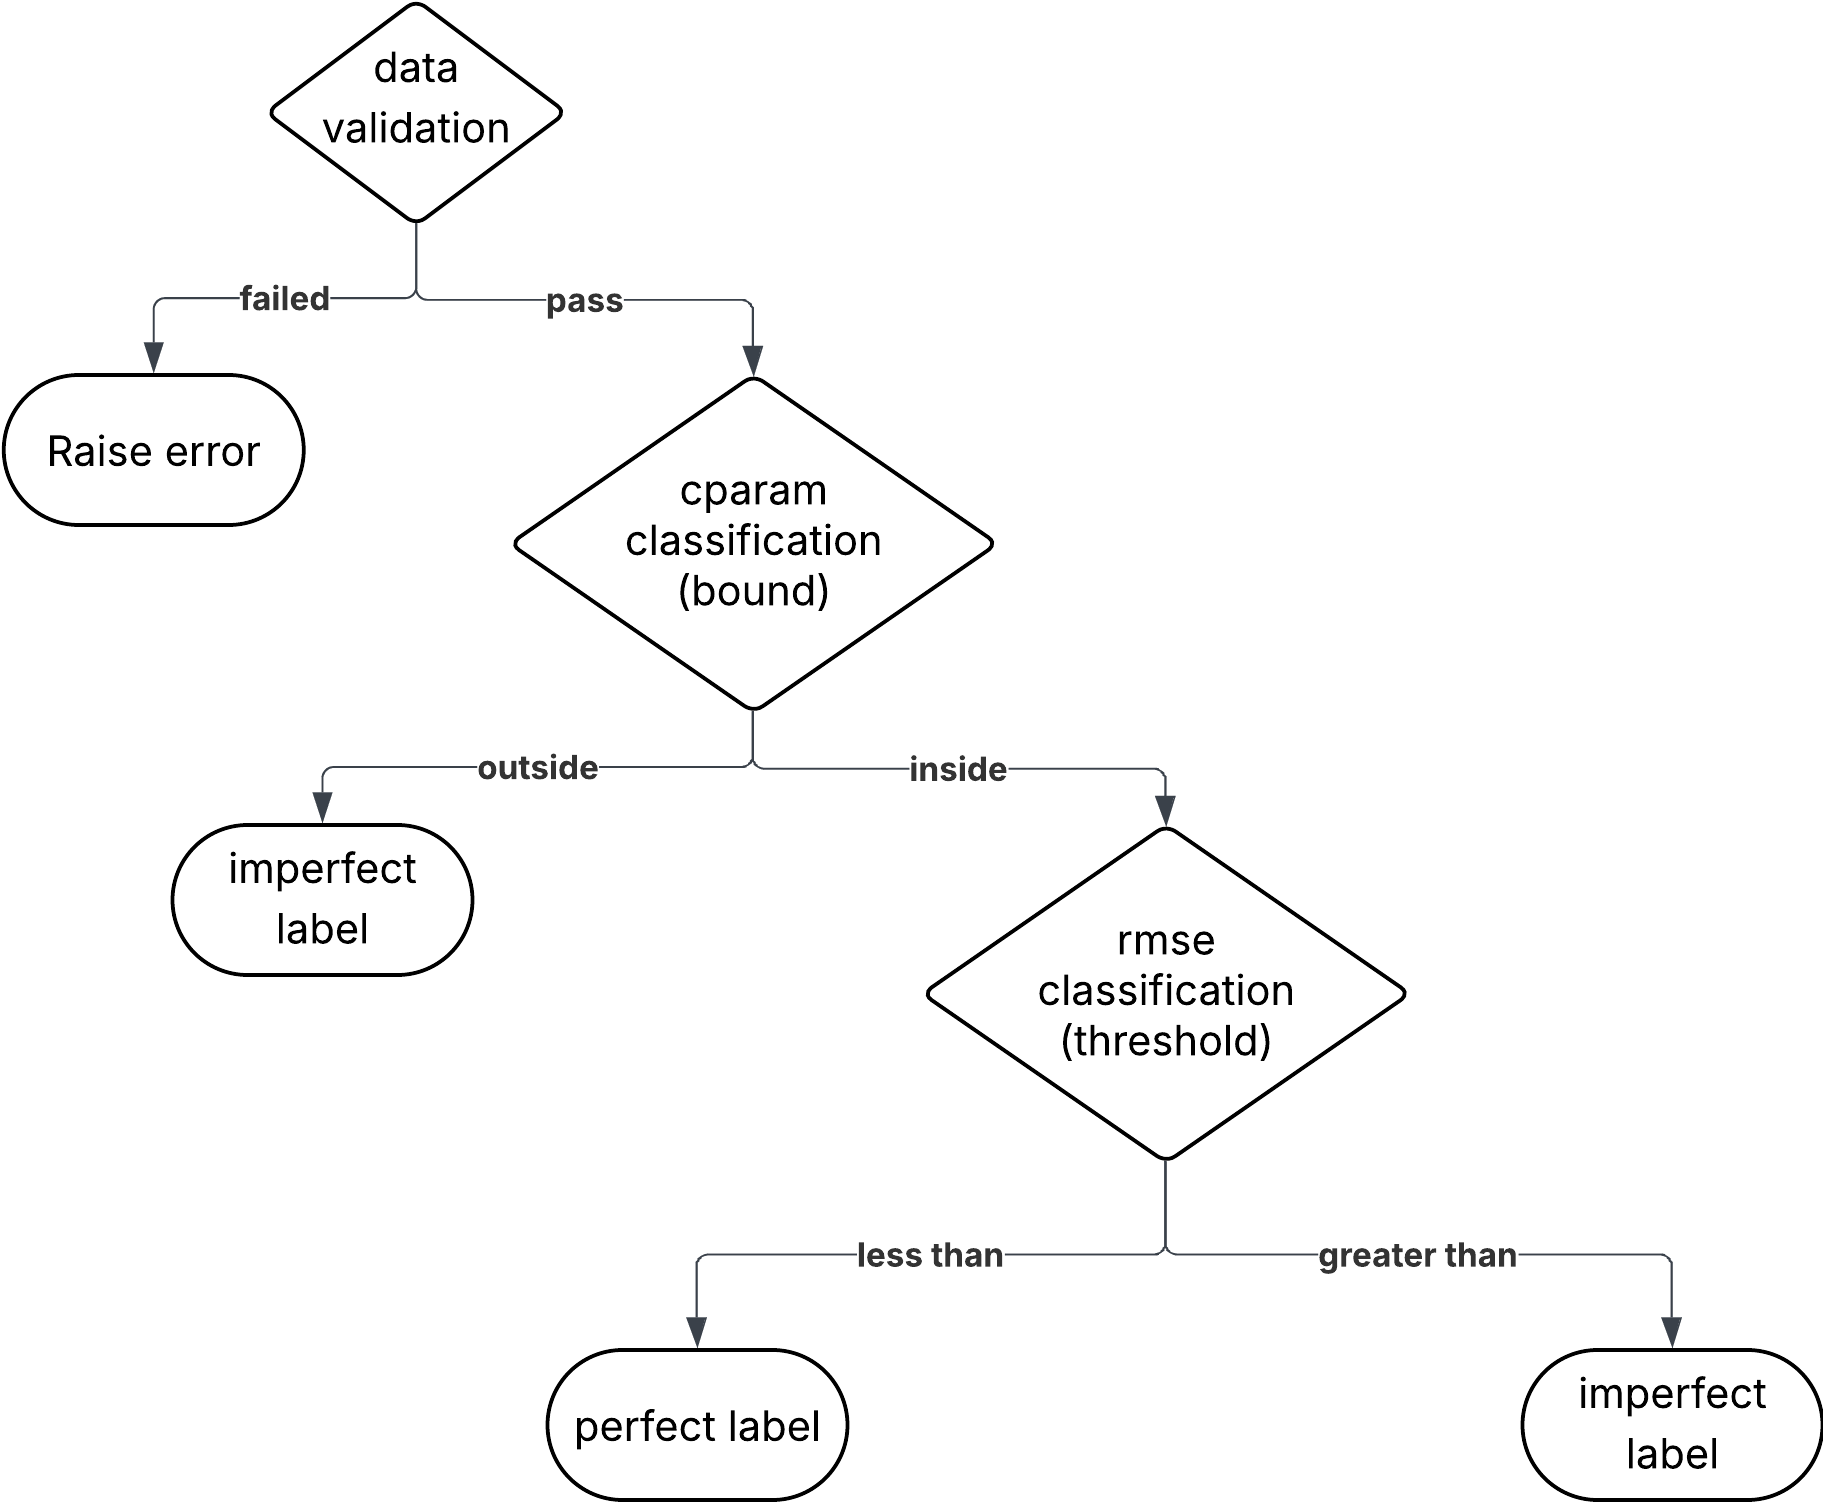

In [25]:
from typing import Collection

class ExperimentClassifier:
    def __init__(self, model_configs):
        """
        Args:
        - model_parameters (dict): A dictionary containing the model parameters 
            for classification. Example structure shown below.

        Example:
        {
            "validation": {
                "min-lower-bound": 0.0,
                "min-upper-bound": 0.5,
                "max-lower-bound": 2.0,
                "max-upper-bound": 14.0,
                "rmse-upper-bound": 5.0,
            },
            "5PL": {
                "cparam-lower-bound": 35.0,
                "cparam-upper-bound": 85.0,
                "rmse-threshold": 0.018,
            }
        }
        """
        self.val_configs = model_configs["validation"]
        self.pred_configs = model_configs["prediction"]
        self.time_axis = np.arange(100)

    @staticmethod
    def logistic_5pl(x, a, b, c, d, g):
        return d + (a - d) / ((1 + (x / c)**b)**g)

    def __call__(self, time_series: Collection[float]) -> bool:
        """
        Classify the time series as perfect or imperfect based on the model parameters.
        Raise error if validation fails.

        Args:
        - time_series: A time series of observations of size 100.
        Returns:
        - bool: True if the time series is classified as perfect, False if imperfect.
        """
        ### data validations
        if not isinstance(time_series, (list, np.ndarray)):
            raise TypeError("Time series must be a list or numpy array.")
        
        if len(time_series) != 100:
            raise ValueError("Time series must have exactly 100 observations.")
        
        min_val = min(time_series)
        max_val = max(time_series)
        
        if (min_val < self.val_configs["min-lower-bound"]):
            raise ValueError(f"Minimum value {min_val} must be greater than or equal to {self.val_configs['min-lower-bound']}.")
        if (min_val > self.val_configs["min-upper-bound"]):
            raise ValueError(f"Minimum value {min_val} must be less than {self.val_configs['min-upper-bound']}.")
        if (max_val < self.val_configs["max-lower-bound"]):
            raise ValueError(f"Maximum value {max_val} must be greater than {self.val_configs['max-lower-bound']}.")
        if (max_val > self.val_configs["max-upper-bound"]):
            raise ValueError(f"Maximum value {max_val} must be less than {self.val_configs['max-upper-bound']}.")
        
        popt, _ = curve_fit(self.logistic_5pl, self.time_axis, time_series, maxfev=10000)
        fitted_values = logistic_5pl(time_axis, *popt)
        rmse = np.sqrt(np.mean((fitted_values - time_series) ** 2))

        if rmse > self.val_configs["rmse-upper-bound"]:
            raise ValueError(f"Curve fitting error. RMSE {rmse} exceeds the upper bound {self.val_configs['rmse-upper-bound']}. ")
        
        ### classify using cparam
        if (popt[2] < self.pred_configs["cparam-lower-bound"] or 
            popt[2] > self.pred_configs["cparam-upper-bound"]):
            return False
        
        ### classify using rmse
        return rmse < self.pred_configs["rmse-threshold"]

classifier = ExperimentClassifier(model_configs)
predictions = [classifier(obs) for obs in observations]

/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: divide by zero encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: overflow encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/923031550.py:2: RuntimeWarning: overflow encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: invalid value encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: divide by zero encountered in divide
  return d + (a - d) / ((1 + (x / c)**b)**g)


## 4. Evaluation

#### 4.1 Evaluation on Training and Holdout Data

As explained previously, we shall include all of the training set for evaluation. This would include the data from initial exploration and the cross validation test set. (No longer proceeding with cross validation.)

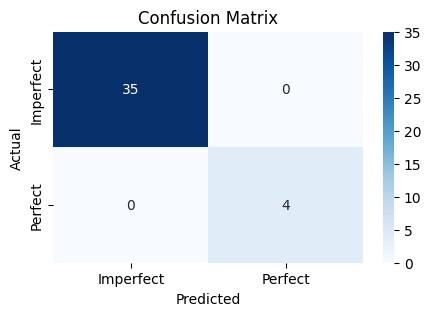

              precision    recall  f1-score   support

   Imperfect       1.00      1.00      1.00        35
     Perfect       1.00      1.00      1.00         4

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(labels, predictions)

### plot confusion matrix

plt.figure(figsize=(5, 3))
sns.heatmap(
    cm, 
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Imperfect', 'Perfect'],
    yticklabels=['Imperfect', 'Perfect']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### show classification report
from sklearn.metrics import classification_report
report = classification_report(labels, predictions, target_names=['Imperfect', 'Perfect'])
print(report)

The confusion matrix shows that all 35 imperfect experiments and all 4 perfect experiments were predicted correctly. This includes the data not in the initial exploration and model build, so the result show no evident of overfitting. Never the less, having more data, especially in the perfect category will reduce risk of overfitting.

#### Evaluation on Other Scenarios

We expect the model to have the following behavior in some edge scenario listed below: 

- parabola
- continous baseline
- no plateau
- noisy low plateau
- noisy late plateau

/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: divide by zero encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: invalid value encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: divide by zero encountered in divide
  return d + (a - d) / ((1 + (x / c)**b)**g)


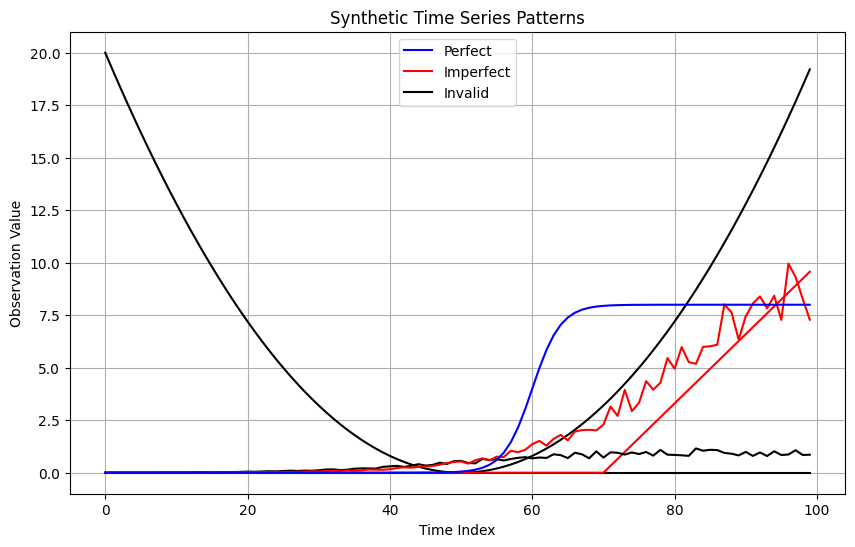

In [27]:
parabola = np.array([0.008 * (i - 50)**2 for i in time_axis])
baseline = np.array([0.01 for _ in time_axis])
no_plateau = np.array([max(i-70, 0)*0.33 for i in time_axis])

### low plateau with noise
low_plateau = 1 / (1 + np.exp(-0.1 * (time_axis - 50)))
low_plateau += np.random.uniform(-1,1, size=low_plateau.shape) * low_plateau *0.2

### late plateau with noise
late_plateau = 10 / (1 + np.exp(-0.1 * (time_axis - 80)))
late_plateau += np.random.uniform(-1,1, size=low_plateau.shape) * late_plateau *0.2

perfect = 8 / (1 + np.exp(-0.5 * (time_axis - 60)))

def color_result(time_series):
    try:
        if classifier(time_series):
            return 'b'  # Perfect
        else:
            return 'r'  # Imperfect
    except ValueError:
        return 'black'  # Invalid
    
plt.figure(figsize=(10, 6))
plt.plot(time_axis, parabola,  color=color_result(parabola))
plt.plot(time_axis, baseline, color=color_result(baseline))
plt.plot(time_axis, no_plateau,  color=color_result(no_plateau))
plt.plot(time_axis, low_plateau,  color=color_result(low_plateau))
plt.plot(time_axis, late_plateau,  color=color_result(late_plateau))
plt.plot(time_axis, perfect,  color=color_result(perfect))
plt.title("Synthetic Time Series Patterns")
plt.xlabel("Time Index")
plt.ylabel("Observation Value")
plt.legend(handles=[
    mlines.Line2D([], [], color='b', label='Perfect'),
    mlines.Line2D([], [], color='r', label='Imperfect'),
    mlines.Line2D([], [], color='black', label='Invalid'),
])
plt.grid()
plt.show()


## 5 Prediction on Evaluation Data

Results are written to "datasets/evaulation_results.csv".

Plot of the result shown below.

In [28]:
eval_path = "datasets/evaluation_data_external.csv"
with open(eval_path, "r") as f:
    labels = f.readline().strip().split(",")
    observations = []
    for idx, row in enumerate(f):
        # print(row.strip().split(","))
        try:
            observations.append(list(map(float, row.strip().split(","))))
        except Exception as e:
            print(f"Error processing row {idx}: {row.strip()}")
            print(e)
            continue

print(labels)
observations = np.array(observations, dtype=np.float32).T
results = [classifier(obs) for obs in observations]
 
with open("datasets/evaluation_results.csv", "w") as f:
    f.write(f"tests,{','.join(labels)}\n")
    f.write(f"results,{','.join(['perfect' if res else 'imperfect' for res in results] )}")

['test1', 'test2', 'test3', 'test4', 'test5', 'test6', 'test7', 'test8', 'test9', 'test10']


/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: divide by zero encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: invalid value encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: divide by zero encountered in divide
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: overflow encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/923031550.py:2: RuntimeWarning: overflow encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)


/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: divide by zero encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: invalid value encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: divide by zero encountered in divide
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/5250814.py:32: RuntimeWarning: overflow encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)
/var/folders/dx/dyw6n3gj5plb5wgjq5__lm040000gn/T/ipykernel_30434/923031550.py:2: RuntimeWarning: overflow encountered in power
  return d + (a - d) / ((1 + (x / c)**b)**g)


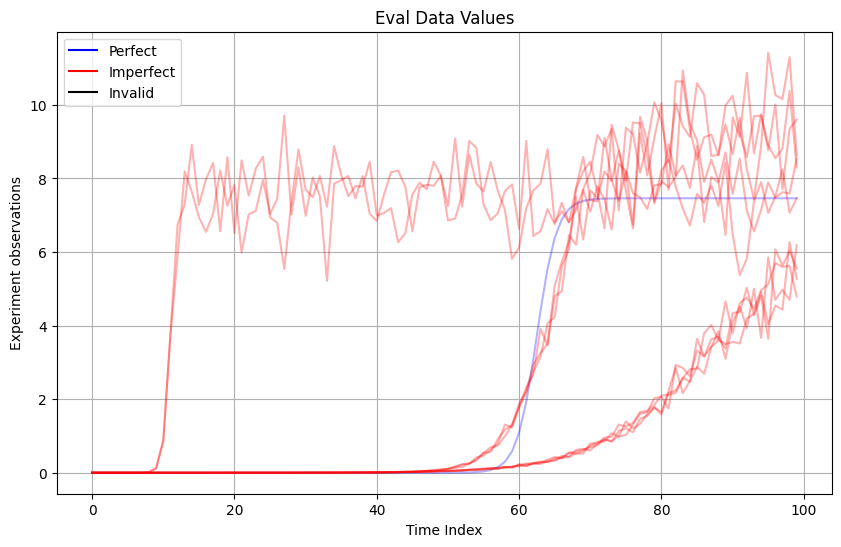

In [29]:
plt.figure(figsize=(10, 6))
time_axis = np.arange(len(observations[0]))

for i in range(len(observations)):
    plt.plot(
        time_axis, 
        observations[i], 
        color=color_result(observations[i]),
        alpha=0.3
    )

plt.title("Eval Data Values")
plt.xlabel("Time Index")
plt.ylabel("Experiment observations")
plt.legend(handles=[
    mlines.Line2D([], [], color='b', label='Perfect'),
    mlines.Line2D([], [], color='r', label='Imperfect'),
    mlines.Line2D([], [], color='black', label='Invalid'),
])
plt.grid()
plt.show()

In [1]:
with open("datasets/evaluation_data_external.csv", 'r', encoding='utf-8') as f:
    print(f.read().replace("\n", "\\n"))

test1,test2,test3,test4,test5,test6,test7,test8,test9,test10\n4.16E-19,5.48E-05,5.03E-05,5.69E-05,5.47E-05,3.82E-08,3.39E-08,4.36E-08,1.93E-09,1.86E-09\n8.46E-19,6.52E-05,5.59E-05,6.09E-05,6.26E-05,5.83E-08,5.39E-08,4.83E-08,1.27E-08,1.25E-08\n1.72E-18,6.35E-05,7.99E-05,7.75E-05,8.04E-05,8.09E-08,5.30E-08,6.95E-08,8.65E-08,8.80E-08\n3.49E-18,8.01E-05,7.53E-05,6.84E-05,7.15E-05,9.13E-08,9.43E-08,7.16E-08,7.70E-07,6.47E-07\n7.10E-18,7.51E-05,9.22E-05,8.45E-05,9.55E-05,1.47E-07,1.25E-07,1.48E-07,5.14E-06,4.88E-06\n1.44E-17,0.000103492,0.000139125,0.000106387,9.76E-05,1.68E-07,1.67E-07,1.25E-07,3.91E-05,4.30E-05\n2.94E-17,0.000130226,0.000152989,0.000139503,0.000136562,2.44E-07,2.49E-07,2.40E-07,0.000288909,0.00027886\n5.97E-17,0.000151452,0.000123614,0.000154349,0.000135138,2.74E-07,3.06E-07,3.01E-07,0.001967196,0.002416881\n1.21E-16,0.000158566,0.000133271,0.000187805,0.000153263,4.15E-07,4.19E-07,4.22E-07,0.015692767,0.017490068\n2.47E-16,0.000166847,0.00019292,0.000143952,0.00022649,6.